<a href="https://colab.research.google.com/github/monetneva/Giotto-TuT/blob/main/giotto_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

In [11]:
digits = datasets.load_digits()
indices = (digits.target == 0) | (digits.target == 8)
y = digits.target[indices]
X = digits.data[indices].reshape([sum(indices), 8, 8])

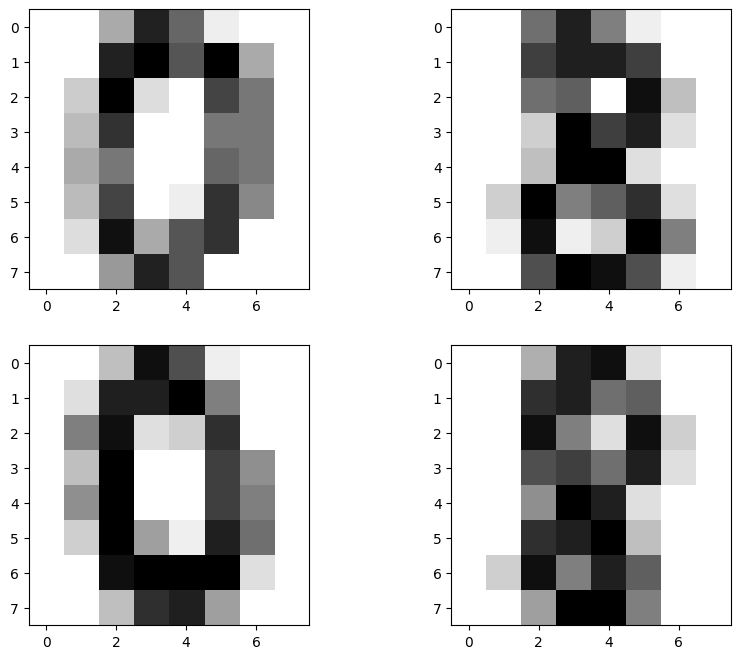

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X[0], cmap='gray_r')
plt.subplot(2,2,2)
_=plt.imshow(X[1], cmap='gray_r')
plt.subplot(2,2,3)
plt.imshow(X[40], cmap='gray_r')
plt.subplot(2,2,4)
_=plt.imshow(X[51], cmap='gray_r')

prep data for persistance images


In [13]:
dists = 1 + 0.5 * np.array([[ y for x in range(8) ] for y in range(8)])

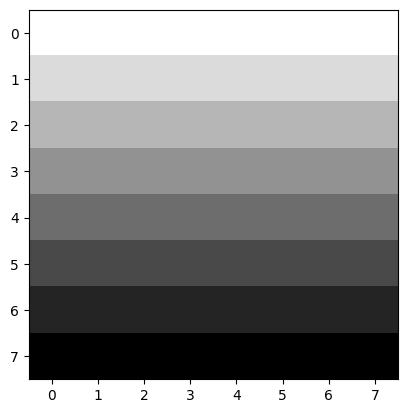

In [14]:
_=plt.imshow(dists, cmap='gray_r')

In [15]:
X_1 = X * dists[np.newaxis,:,:]

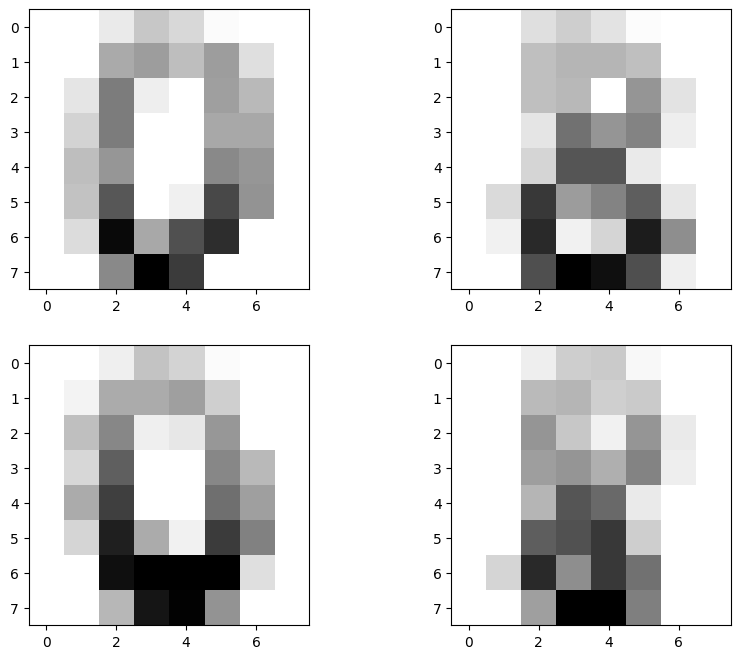

In [16]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X_1[0], cmap='gray_r')
plt.subplot(2,2,2)
_=plt.imshow(X_1[1], cmap='gray_r')
plt.subplot(2,2,3)
plt.imshow(X_1[40], cmap='gray_r')
plt.subplot(2,2,4)
_=plt.imshow(X_1[51], cmap='gray_r')

In [1]:
!pip install giotto-tda

In [17]:
from gtda.homology import CubicalPersistence

In [18]:
cp = CubicalPersistence(homology_dimensions=[1], coeff=2, periodic_dimensions=None)

persistence = cp.fit_transform(-X_1)

In [29]:
!pip install gudhi
import gudhi

/usr/local/lib/python3.11/dist-packages/gudhi/persistence_graphical_tools.py:129: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


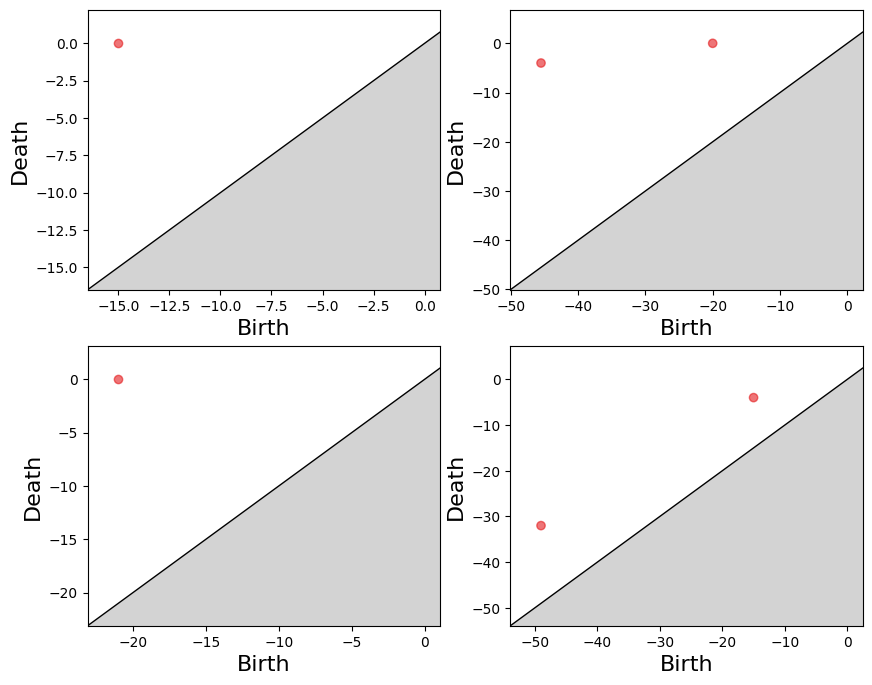

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
gudhi.plot_persistence_diagram(persistence[0][persistence[0,:,0] != persistence[0,:,1]][:,[0,1]], axes=axs[0][0])
gudhi.plot_persistence_diagram(persistence[1][persistence[1,:,0] != persistence[1,:,1]][:,[0,1]], axes=axs[0][1])
gudhi.plot_persistence_diagram(persistence[40][persistence[40,:,0] != persistence[40,:,1]][:,[0,1]], axes=axs[1][0])
gudhi.plot_persistence_diagram(persistence[51][persistence[51,:,0] != persistence[51,:,1]][:,[0,1]], axes=axs[1][1])
_=[[a.set_title("") for a in ax] for ax in axs]

In [31]:
from gtda.diagrams import PersistenceImage

In [36]:
pi_res = 20
sigma = 2
pi = PersistenceImage(sigma=sigma, n_bins=pi_res, weight_function=None)

persistence_images = pi.fit_transform(persistence)[:,0]

extent = [min(pi.samplings_[1][0]), max(pi.samplings_[1][0]), min(pi.samplings_[1][1]), max(pi.samplings_[1][1])]

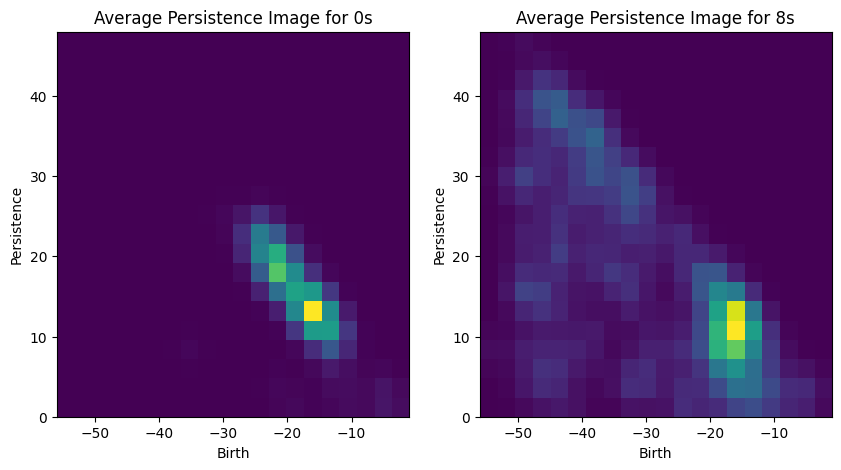

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.mean(persistence_images[y == 0], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
plt.title("Average Persistence Image for 0s")
plt.subplot(1,2,2)
plt.imshow(np.mean(persistence_images[y == 8], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Average Persistence Image for 8s")

ML to classify 0 vs 8:

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    persistence_images.reshape(len(y), pi_res**2), y, test_size=0.3, random_state=2)

# **SVM**

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
# SVM = drawing a line to best split data ( not super clear from the diagram)

In [41]:
clf = make_pipeline(StandardScaler(),
                    SVC(kernel='linear')).fit(X_train, y_train)

Accuracy: 0.93396226


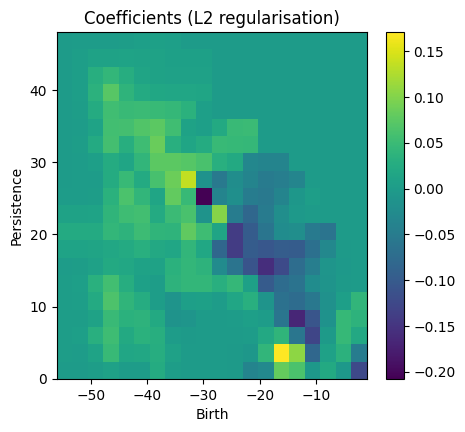

In [42]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.steps[1][1].coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L2 regularisation)")

## **Logistic Regression** Classifier, closer to 1 is probability of being 8

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
clf = LogisticRegression(fit_intercept=False, penalty='l2').fit(X_train, y_train)

Accuracy: 0.81132075


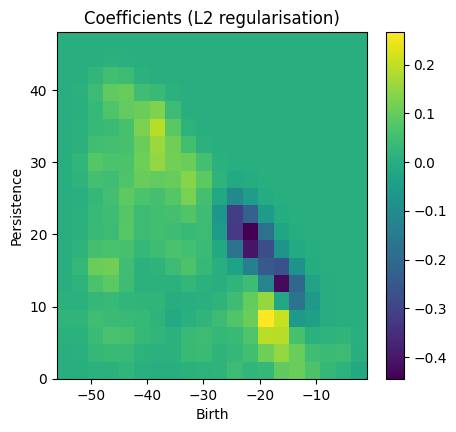

In [45]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L2 regularisation)")

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

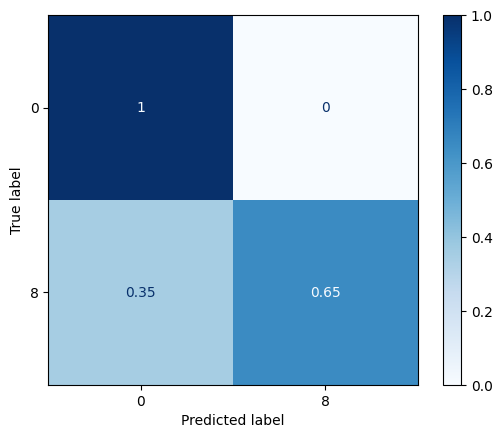

In [49]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
                                      display_labels=["0", "8"],
                                      cmap=plt.cm.Blues,
                                      normalize='true')
plt.show()

# **Logistic Regression with L1 regularisation** to find most important components


In [50]:
clf = LogisticRegression(fit_intercept=False, penalty='l1', solver='liblinear', C=1).fit(X_train, y_train)

Accuracy: 0.46226415


Text(0.5, 1.0, 'Coefficients (L1 regularisation)')

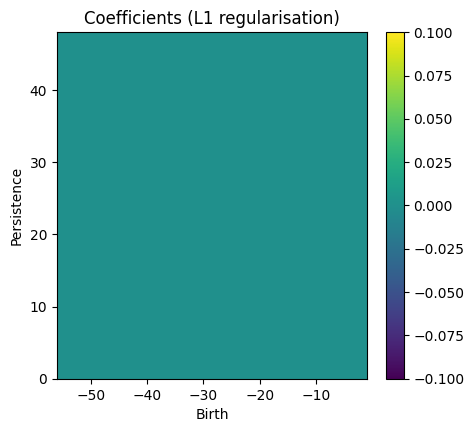

In [52]:
print("Accuracy: " + str(clf.score(X_test, y_test))[:10])
plt.figure(figsize=(5,4.5))
plt.imshow(clf.coef_.reshape([pi_res, pi_res]), aspect='auto', extent=extent)
plt.colorbar()
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Coefficients (L1 regularisation)")

All digits


In [53]:
y_all = digits.target
X_all = digits.data.reshape([len(y_all), 8, 8])

In [54]:
X_1_all = X_all * dists[np.newaxis,:,:]
persistence_all = cp.fit_transform(-X_1_all)
persistence_images_all = pi.fit_transform(persistence_all)[:,0]

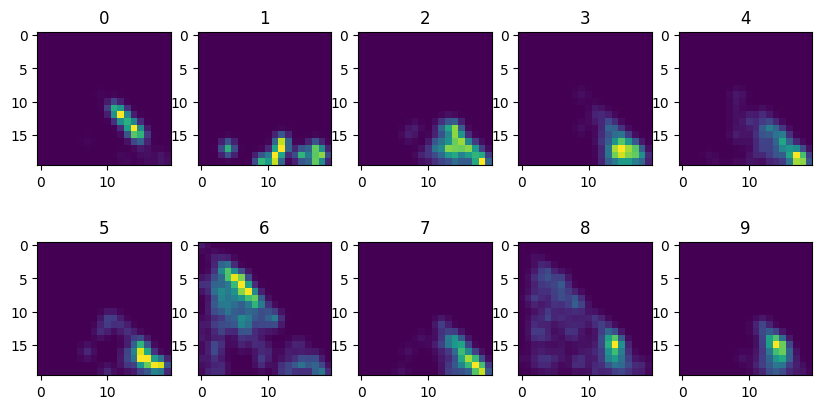

In [55]:
plt.figure(figsize=(10,5))
for yval in range(0,10):
    plt.subplot(2,5,yval+1)
    plt.imshow(np.mean(persistence_images_all[y_all == yval], axis=0).reshape([pi_res, pi_res]))
    plt.title(str(yval))

In [56]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    persistence_images_all.reshape(len(y_all), pi_res**2), y_all, test_size=0.3, random_state=5)


In [58]:
""" clf = make_pipeline(StandardScaler(), SVC(kernel='linear')).fit(X_all_train, y_all_train)
print("Accuracy: " + str(clf.score(X_all_test, y_all_test))[:10])
_=plt.figure(figsize=(10,7))
ax = plt.axes()
_=plot_confusion_matrix(clf, X_all_test, y_all_test, display_labels=[str(i) for i in range(10)],
                      cmap=plt.cm.Blues, normalize='true', ax=ax) """


' clf = make_pipeline(StandardScaler(), SVC(kernel=\'linear\')).fit(X_all_train, y_all_train)\nprint("Accuracy: " + str(clf.score(X_all_test, y_all_test))[:10])\n_=plt.figure(figsize=(10,7))\nax = plt.axes()\n_=plot_confusion_matrix(clf, X_all_test, y_all_test, display_labels=[str(i) for i in range(10)],\n                      cmap=plt.cm.Blues, normalize=\'true\', ax=ax) '